### DATAFRAME

In [1]:
from cloudvolume import CloudVolume
from meshparty import skeletonize, trimesh_io
from caveclient import CAVEclient
import trimesh
import numpy as np
import datetime
import networkx as nx
from scipy.sparse import identity
from scipy.spatial import distance_matrix
import scipy 
from tqdm import tqdm
# import aws
import pandas as pd
import csv
import pyembree
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import itertools
import math

In [2]:
orphans = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/ALL_ORPHANS.csv")

In [3]:
orphans_subset = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/Orphans_subset.csv")

In [4]:
def my_array(x):
    res = list(map(str.strip, x.split('; ')))
    return res

In [5]:
orphans['endpoints'] = orphans['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [6]:
orphans_subset['endpoints'] = orphans_subset['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [7]:
## convert from string list to 2-d array
def convert_to_array(row):
    count = 0
    result = []
    for endpoint in row["endpoints"]:
        endpoint = eval(endpoint)
        if(count == 0):
            result = np.array(endpoint)
            count = count + 1
        else:
            result = np.vstack((result, np.array(endpoint)))
            count = count + 1
    if(count == 1 and result.size != 0):
        result = result.reshape(1,3)
    return result 

In [8]:
orphans["real_endpoints"] = orphans.apply(convert_to_array, axis = 1)

In [9]:
orphans_subset["real_endpoints"] = orphans_subset.apply(convert_to_array, axis = 1)

### TIP FINDER FUNCTIONS

In [10]:
def get_and_process_mesh(root_id):
    datastack_name = "minnie65_phase3_v1"
    client = CAVEclient(datastack_name)
    vol = CloudVolume(
        client.info.segmentation_source(),
        use_https=True,
        progress=False,
        bounded=False,
        fill_missing=True,
        secrets={"token": client.auth.token}
    )
    print("Downloading Mesh")
    mesh = vol.mesh.get(str(root_id))[root_id]
    mesh_obj = trimesh.Trimesh(np.divide(mesh.vertices, np.array([1,1,1])), mesh.faces)
    print("Vertices: ", mesh.vertices.shape[0])

    if mesh_obj.volume > 4000000000000:
        print("TOO BIG, SKIPPING")
        return None
    trimesh.repair.fix_normals(mesh_obj)
    mesh_obj.fill_holes()

    return mesh_obj

In [11]:
def get_soma(soma_id:str):
    cave_client = CAVEclient('minnie65_phase3_v1')
    soma = cave_client.materialize.query_table(
        "nucleus_neuron_svm",
        filter_equal_dict={'id':soma_id}
    )
    return soma

In [12]:
def process_mesh_ccs(mesh_obj):
    print("Processing CC's")
    ccs_graph = trimesh.graph.connected_components(mesh_obj.edges)
    ccs_len = [len(c) for c in ccs_graph]
    largest_component = ccs_graph[np.argmax(ccs_len)]
    largest_component_remap = np.arange(ccs_graph[np.argmax(ccs_len)].shape[0])
    face_dict = {largest_component[i]:largest_component_remap[i] for i in range(largest_component.shape[0])}

    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces = new_faces[new_faces[:, 0] != None]
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[largest_component], new_faces)

    all_ids = set(largest_component)
    encapsulated_ids = []

    for i in range(1, len(ccs_graph)):
        n_con = largest_component_mesh.contains(mesh_obj.vertices[ccs_graph[i]])
        if np.sum(n_con) / n_con.shape[0] == 0 and n_con.shape[0] > 50:
            all_ids.update(ccs_graph[i])
        else:
            if len(ccs_graph[i]) < 1000:
                encapsulated_ids.append((np.mean(mesh_obj.vertices[ccs_graph[i]], axis=0)/[4,4,40], len(ccs_graph[i])))
            
    all_component = np.array(list(ccs_graph[np.argmax(ccs_len)]))
    all_component_remap = np.arange(all_component.shape[0])
    face_dict = {all_component[i]:all_component_remap[i] for i in range(all_component.shape[0])}
    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces[new_faces[:, 0] != None]
    
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[all_component], new_faces)
    
    mesh_obj = largest_component_mesh
    return mesh_obj, encapsulated_ids, np.max(ccs_len)

In [13]:
def process_defects(mesh_obj, a=.75):
    bad_edges = trimesh.grouping.group_rows(
        mesh_obj.edges_sorted, require_count=1)
    bad_edges_ind = mesh_obj.edges[bad_edges]
    sparse_edges = mesh_obj.edges_sparse
    xs = list(bad_edges_ind[:, 0]) + list(bad_edges_ind[:, 1]) 
    ys = list(bad_edges_ind[:, 1]) + list(bad_edges_ind[:, 0])
    vs = [1]*bad_edges_ind.shape[0]*2
    bad_inds = scipy.sparse.coo_matrix((vs, (xs, ys)), shape=(mesh_obj.vertices.shape[0], mesh_obj.vertices.shape[0]))
    # Make it symmetrical and add identity so each integrates from itself too, then subtract singleton edges
    # I noticed that the number of asymmetrical edges vs the number of single edges I find from group rows
    # Are close but different. Haven't looked into that yet. Also removing edges 1 hop away from single edges to remove bias towards
    # Holes in the mesh that are caused by mesh construction errors as opposed to segmentation errors
    sparse_edges = mesh_obj.edges_sparse + mesh_obj.edges_sparse.T + identity(mesh_obj.edges_sparse.shape[0]) - sparse_edges.multiply(bad_inds) - bad_inds
    degs = mesh_obj.vertex_degree + 1

    # N_iter is a smoothing parameter here. The loop below smooths the vertex error about the mesh to get more consistent connected regions
    n_iter = 2
    angle_sum = np.array(abs(mesh_obj.face_angles_sparse).sum(axis=1)).flatten()
    defs = (2 * np.pi) - angle_sum

    abs_defs = np.abs(defs)
    abs_defs_i = abs_defs.copy()
    for i in range(n_iter):
        abs_defs_i = sparse_edges.dot(abs_defs_i) / degs
    
    verts_select = np.argwhere((abs_defs_i > a))# & (abs_defs < 2.5))

    edges_mask = np.isin(mesh_obj.edges, verts_select)
    edges_mask[bad_edges] = False
    edges_select = edges_mask[:, 0] * edges_mask[:, 1]
    edges_select = mesh_obj.edges[edges_select]

    G = nx.from_edgelist(edges_select)#f_edge_sub)

    ccs = nx.connected_components(G)
    subgraphs = [G.subgraph(cc).copy() for cc in ccs]

    lens = []
    lengths = []
    for i in tqdm(range(len(subgraphs))):
        ns = np.array(list(subgraphs[i].nodes()))
    #     ns = ns[abs_defs[ns ]]
        l = len(ns)
        if l > 20 and l < 5000:
            lens.append(ns)
            lengths.append(l)
    all_nodes = set()
    for l in lens:
        all_nodes.update(l)
    all_nodes = np.array(list(all_nodes))
    # sharp_pts = mesh_obj.vertices[all_nodes]
    centers = np.array([np.mean(mesh_obj.vertices[list(ppts)],axis=0) for ppts in lens])

    return centers, lens

In [14]:
def process_endpoints(mesh_obj, skel_mp):
    # Process the skeleton to get the endpoints
    interior_cc_mask = set()
    el = nx.from_edgelist(skel_mp.edges)
    comps = list(nx.connected_components(el))
    for c in comps:
        if len(c) < 100:
            n_con = mesh_obj.contains(skel_mp.vertices[list(c)])
            if np.sum(n_con) / n_con.shape[0] > .10:
                interior_cc_mask.update(list(c))
    # Process the skeleton to get the endpoints
    edges = skel_mp.edges.copy()

    edge_mask = ~np.isin(edges, interior_cc_mask)
    edge_mask = edge_mask[:, 0] + edge_mask[:, 1]
    edges = edges[edge_mask]
    edges_flat  = edges.flatten()
    edge_bins = np.bincount(edges_flat) 

    eps = np.squeeze(np.argwhere(edge_bins==1))
    eps_nm = skel_mp.vertices[eps]

    eps_comp = distance_matrix(eps_nm, eps_nm)
    eps_comp[eps_comp == 0] = np.inf
    eps_thresh = np.argwhere(~(np.min(eps_comp, axis=0) < 3000))

    eps = np.squeeze(eps[eps_thresh])
    eps_nm = np.squeeze(eps_nm[eps_thresh])
    return eps, eps_nm

In [15]:
def process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp):
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    print("Processing mesh errors")
    # path_to_root_dict = {}
    # for ep in eps:
    #     path_to_root_dict[ep] = skel_mp.path_to_root(ep)
        
    dists_defects = np.zeros(centers.shape[0])
    sizes = np.zeros(centers.shape[0])
    mesh_map = skel_mp.mesh_to_skel_map
    closest_skel_pts = mesh_map[[l[0] for l in lens]]

    # print(centers, eps_nm)

    dist_matrix = distance_matrix(centers, eps_nm)
    ct = 0

    closest_tip = np.zeros((centers.shape[0]))

    for center in tqdm(centers):
    #     skel_pts_dists = np.linalg.norm(skel_mp.vertices - center, axis=1)
    #     ep_pts_dists = np.linalg.norm(eps_nm - center, axis=1)
        
        # closest_skel_pt = closest_skel_pts[ct]
        min_ep = np.inf
        eps_hit = []
        if eps.size == 1:
            eps_hit.append(eps)
        else: 
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
        if(eps.size == 1):
            dists = dist_matrix[ct]
        else:
            dists = dist_matrix[ct, eps_hit]
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip[ct] = tip_hit
    #     print(np.argmin(ep_pts_dists), ep_found, eps_nm[np.argmin(ep_pts_dists)]/[4,4,40], eps_nm[j]/[4,4,40], center/[4,4,40])
        dists_defects[ct] = min_dist
        sizes[ct] = len(lens[ct])
        ct+=1
    dists_defects_sub = dists_defects[dists_defects < 5000]
    sizes_sub = sizes[dists_defects < 5000]
    centers_sub = centers[dists_defects < 5000]
    tips_hit_sub = closest_tip[dists_defects < 5000]
    closest_skel_pts_sub = closest_skel_pts[dists_defects < 5000]
    inds_sub = np.arange(centers.shape[0])[dists_defects < 5000]


    # Also ranking each component based on its PCA- if the first component is big enough, the points are mostly linear
    # These point sets seem to be less likely to be true errors
    from sklearn.decomposition import PCA
    pca_vec = np.zeros(inds_sub.shape[0])
    for i in range(inds_sub.shape[0]):
        pca = PCA()#n_components=2)
        pca.fit(mesh_obj.vertices[lens[inds_sub[i]]])

        pca_vec[i] = pca.explained_variance_ratio_[0]

    dists_defects_sub[dists_defects_sub < 4000] = 100
    dists_defects_norm = dists_defects_sub #/ np.max(dists_defects_sub)
    ranks_ep = sizes_sub / dists_defects_norm * (1-pca_vec)
    ranks = sizes_sub**2 * (1-pca_vec)

    #ranks_ep_errors_filt = ranks_ep[ranks_ep > .1]
    centers_ep_send_errors = centers_sub[np.argsort(ranks_ep)][::-1][:20]
    final_mask_eps = np.full(centers_ep_send_errors.shape[0], True)
    tips_hit_send_ep = tips_hit_sub[np.argsort(ranks_ep)][::-1][:20]
    uns, nums = np.unique(tips_hit_send_ep, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_eps[np.argwhere(tips_hit_send_ep == un)[1:]] = False
    centers_errors_ep = centers_ep_send_errors[final_mask_eps]
    centers_errors = centers_sub[np.argsort(ranks)[::-1]][:20]
    return centers_errors, centers_errors_ep

In [16]:
def process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm, facet_area_threshold=30000):

    
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    #changed threshold of facets to 3000 to match changes performed on processed in analysis CELLS
    print("Processing facets")
    #can possibly change param here
    #threshold on size of flat area
    locs = np.argwhere(mesh_obj.facets_area > facet_area_threshold)

    mesh_map = skel_mp.mesh_to_skel_map
    mesh_coords = mesh_obj.vertices[mesh_obj.faces]
    mean_locs = []
    mesh_ind = []
    fs = []
    for l in tqdm(locs):
        fs.append(np.sum(mesh_obj.facets_area[l]))
        fc = mesh_obj.facets[l[0]]
        vert_locs = mesh_coords[fc]
        mean_locs.append(np.mean(vert_locs[:, 0], axis=0))
        mesh_ind.append(fc[0])
    mesh_ind = mesh_obj.faces[mesh_ind][:, 0]
    mean_locs = np.array(mean_locs)
    if mean_locs.size == 0:
        facets_send_final = np.zeros((1,3))
        return facets_send_final
    dists_defects_facets = np.zeros(mean_locs.shape[0])
    mesh_map_facets = skel_mp.mesh_to_skel_map
    closest_skel_pts_facets = mesh_map[[m for m in mesh_ind]]
    dist_matrix_facets = distance_matrix(mean_locs, eps_nm)
    ct = 0

    closest_tip_facets = np.zeros((mean_locs.shape[0]))

    for center in tqdm(mean_locs):

        closest_skel_pt = closest_skel_pts_facets[ct]
        eps_hit = []
        ##added for error fixing
        if eps.size == 1:
            eps_hit.append(eps)
        else:
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
            #distance from every error(facets and jagged) to every endpoint
        if(eps.size == 1):
            dists = dist_matrix_facets[ct]
        else:
            dists = dist_matrix_facets[ct, eps_hit]
    
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip_facets[ct] = tip_hit
        dists_defects_facets[ct] = min_dist
        ct+=1
    dists_defects_sub_facets = dists_defects_facets[dists_defects_facets < 2000]
    sizes_sub_facets = np.array(fs)[dists_defects_facets < 2000]
    mean_locs_facets = mean_locs[dists_defects_facets < 2000]
    tips_hit_sub_facets = closest_tip_facets[dists_defects_facets < 2000]
    closest_skel_pts_sub_facets = closest_skel_pts_facets[dists_defects_facets < 2000]
    inds_sub_facets = np.arange(mean_locs.shape[0])[dists_defects_facets < 2000]
    # ranks_ep_facets = sizes_sub_facets**2 / dists_defects_sub_facets
    #ranks_ep_facets_filt = ranks_ep_facets[ranks_ep_facets > 2e7]
    mean_locs_send_facets = mean_locs_facets
    final_mask_facets = np.full(mean_locs_send_facets.shape[0], True)
    tips_hit_send_facets = tips_hit_sub_facets
    uns, nums = np.unique(tips_hit_send_facets, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_facets[np.argwhere(tips_hit_send_facets == un)[1:]] = False
    facets_send_final = mean_locs_send_facets[final_mask_facets] / [4,4,40]
    return facets_send_final

### TIP FINDER FUNCTION

In [17]:
def error_locs_defects(root_id, soma_id = None, soma_table=None, center_collapse=True):
    mesh_obj = get_and_process_mesh(root_id)
    if mesh_obj is None:
        return None
    try:
        if soma_table==None:
            soma_table = get_soma(str(soma_id))
        if soma_table[soma_table.id == soma_id].shape[0] > 0:
            center = np.array(soma_table[soma_table.id == soma_id].pt_position)[0] * [4,4,40]
        else:
            center=None
    except:
        center = None
    print("Subselecting largest connected component of mesh")
    mesh_obj, encapsulated_ids, max_verts = process_mesh_ccs(mesh_obj)
    

    skel_mp = skeletonize.skeletonize_mesh(trimesh_io.Mesh(mesh_obj.vertices, 
                                            mesh_obj.faces),
                                            invalidation_d=4000,
                                            shape_function='cone',
                                            collapse_function='branch',
#                                             soma_radius = soma_radius,
                                            soma_pt=center,
                                            smooth_neighborhood=5,
                                             cc_vertex_thresh=max_verts - 10
#                                                     collapse_params = {'dynamic_threshold':True}
                                            )
    print("Skel done")
    centers, lens = process_defects(mesh_obj)
    eps, eps_nm = process_endpoints(mesh_obj, skel_mp)

    if(len(eps) == 0):
        sorted_encapsulated_send = np.zeros((1,3))
        facets_send_final = np.zeros((1,3))
        errors_send = np.zeros((1,3))
        errors_tips_send = np.zeros((1,3))
        return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send
        
    
    if len(centers) !=0:
        centers_errors, centers_errors_ep = process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp)
    else:
        centers_errors = np.zeros ((1,3))
        centers_errors_ep = np.zeros ((1,3))
        ranks = np.zeros ((1))
        ranks_ep = np.zeros((1, 3))
        ranks_return = 0
        ranks_ep_return = 0
    facets_send_final = process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm)
    errors_send = centers_errors / [4,4,40]
    errors_tips_send = centers_errors_ep / [4,4,40]
    encapsulated_centers = [e[0] for e in encapsulated_ids]
    encapsulated_lens = [e[1] for e in encapsulated_ids]
    sorted_encapsulated_send = np.array(encapsulated_centers)[np.argsort(encapsulated_lens)][::-1]
    return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send

### Generating Endpoints

In [18]:
def find_endpoints_and_counts(row):
    from scipy.spatial import distance_matrix

    seg_id = row["seg_id"]
    sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send = error_locs_defects(seg_id)
    
    together = np.vstack((facets_send_final, errors_tips_send))
    if len(together) == 0:
        num_points_error_tips_send = 0
        num_points_facets_send_final = 0
        return together, num_points_error_tips_send, num_points_facets_send_final, facets_send_final, errors_tips_send

    num_points_error_tips_send  = np.sum(np.all(errors_tips_send != 0, axis=1))
    num_points_facets_send_final = np.sum(np.all(facets_send_final != 0, axis=1))
    mask = np.sum(together, axis=1)
    together = together[mask > 0]


    return together, num_points_error_tips_send, num_points_facets_send_final, facets_send_final, errors_tips_send   

In [19]:
def generate_endpoints(dataframe):
    dataframe["endpoints_generated"], dataframe["num_errors"], dataframe["num_facets"], dataframe["facets"], dataframe["errors"] = zip(*dataframe.apply(find_endpoints_and_counts, axis=1))
    return dataframe

### Accuracy Function

In [20]:
def pred_eps_acc(gt_endpoints, pred_endpoints, threshold):
    # Calculate distances
    dist_matrix = np.array(spatial.distance.cdist(gt_endpoints, pred_endpoints, metric = 'euclidean'))
    # Apply threshold
    dist_matrix[dist_matrix > threshold] = 0
    # Calculating accuracy
    valid_eps = np.count_nonzero(dist_matrix, axis = 1)
    accuracy = np.count_nonzero(valid_eps) / len(gt_endpoints)
    return accuracy

### Filtering Facets + Errors Function

In [21]:
def filter_facets_errors(row):
    
    # distance matrix calculation between all points in together
    dists = distance_matrix(row["endpoints_generated"], row["endpoints_generated"], p=2)
    #distance matrix between all points in together and true endpoints
    dists_to_gt = distance_matrix(row["endpoints_generated"], row["real_endpoints"])
    #filtered points keeps one point based on a threshold. Any other points within threshold is not kept
    filtered_points = []
    N = row["endpoints_generated"].shape[0]  # Number of points
    filtered_indices = []

    for i in range(N):
        if i in filtered_indices:
            continue
        keep_index = i
        for j in range(i + 1, N):
            if j in filtered_indices:
                continue
            distance = dists[i, j]
            if distance <= 250 and distance > 0:
                #pick the endpoint closest to the gt endpoint
                #dist j to gt
                min_dist = np.min(dists_to_gt[keep_index])
                min_dist_2 = np.min(dists_to_gt[j])
                if min_dist <= min_dist_2:
                    #i is better than j
                    keep_index = i
                    filtered_indices.append(j)
                else:
                    #j is better than i
                    keep_index = j
                    filtered_indices.append(i)
        #out of the group of clustered points, this is closest to gt so we keep it and filter others out
        filtered_points.append(row["endpoints_generated"][keep_index])
        
    filtered_points = np.array(filtered_points)
    filtered_points = np.unique(filtered_points, axis = 0)

    if len(filtered_points) == 0:
        filtered_points =filtered_points.reshape((0, 3))

    #update the num_errors	num_facets	facets	errors
    for index in filtered_indices:
        if np.isin(row["endpoints_generated"][index], row["errors"]).any():
            #remove errors and decremeent count
            row["errors"] = row["errors"][row["errors"] != row["endpoints_generated"][index]]
            row["num_errors"] = row["num_errors"] - 1
        else:
            #remove from facets and decrement count
            row["facets"] = row["facets"][row["facets"] != row["endpoints_generated"][index]]
            row["num_facets"] = row["num_facets"] - 1

    return filtered_points, row["num_facets"], row["num_errors"], row["facets"], row["errors"]

### Testing On Orphans

In [ ]:
generate_endpoints(orphans)

In [23]:
generate_endpoints(orphans_subset)

Vertices:  7993
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7992/7992 [00:00<00:00, 1293443.34it/s]


Skel done


100%|██████████| 26/26 [00:00<00:00, 147566.85it/s]


Processing facets


100%|██████████| 17/17 [00:00<00:00, 80206.04it/s]


Vertices:  21335
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 21334/21334 [00:00<00:00, 1106934.71it/s]


Skel done


100%|██████████| 87/87 [00:00<00:00, 250105.86it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 28630.06it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 104563.88it/s]


Vertices:  6056
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 6049/6049 [00:00<00:00, 1186796.94it/s]


Skel done


100%|██████████| 51/51 [00:00<00:00, 218945.24it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 44501.90it/s]


Processing facets


100%|██████████| 48/48 [00:00<00:00, 60385.90it/s]


Vertices:  1180
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1179/1179 [00:00<00:00, 388306.59it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 75497.47it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 66109.87it/s]


Vertices:  14714
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14505/14505 [00:00<00:00, 1415076.40it/s]


Skel done


100%|██████████| 91/91 [00:00<00:00, 265240.91it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 27533.72it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 116883.07it/s]


Vertices:  24966
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24965/24965 [00:00<00:00, 833857.32it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 280211.43it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 68759.08it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 94004.80it/s]


Vertices:  23312
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 23105/23105 [00:00<00:00, 954480.84it/s]


Skel done


100%|██████████| 168/168 [00:00<00:00, 282875.58it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 64375.39it/s]


Processing facets


100%|██████████| 71/71 [00:00<00:00, 70668.15it/s]


Vertices:  2490
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2489/2489 [00:00<00:00, 633972.35it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 132252.83it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]


Processing facets


100%|██████████| 5/5 [00:00<00:00, 59409.41it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7232/7232 [00:00<00:00, 1290006.23it/s]


Skel done


100%|██████████| 50/50 [00:00<00:00, 112387.57it/s]


Processing facets


100%|██████████| 6/6 [00:00<00:00, 59493.67it/s]


Vertices:  2238
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2237/2237 [00:00<00:00, 663366.66it/s]


Skel done


100%|██████████| 8/8 [00:00<00:00, 79891.50it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 34485.54it/s]


Vertices:  7187
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7186/7186 [00:00<00:00, 1278918.34it/s]


Skel done


100%|██████████| 39/39 [00:00<00:00, 207323.01it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 73973.62it/s]


Vertices:  44825
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 44696/44696 [00:00<00:00, 900996.85it/s]


Skel done


100%|██████████| 250/250 [00:00<00:00, 300193.53it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 54379.36it/s]

Processing facets



100%|██████████| 295/295 [00:00<00:00, 104830.95it/s]


Vertices:  11531
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11530/11530 [00:00<00:00, 1394352.42it/s]


Skel done


100%|██████████| 77/77 [00:00<00:00, 250746.43it/s]


Processing mesh errors


100%|██████████| 6/6 [00:00<00:00, 55067.45it/s]


Processing facets


100%|██████████| 62/62 [00:00<00:00, 78492.86it/s]


Vertices:  3820
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3801/3801 [00:00<00:00, 963703.65it/s]


Skel done


100%|██████████| 28/28 [00:00<00:00, 160000.70it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 28055.55it/s]


Processing facets


100%|██████████| 14/14 [00:00<00:00, 75185.99it/s]


Vertices:  24046
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24033/24033 [00:00<00:00, 936879.80it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 310555.44it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 49932.19it/s]


Processing facets


100%|██████████| 43/43 [00:00<00:00, 76389.27it/s]


Vertices:  3065
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3060/3060 [00:00<00:00, 769181.96it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 81005.87it/s]


Processing facets


100%|██████████| 16/16 [00:00<00:00, 56968.48it/s]


Vertices:  5754
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5753/5753 [00:00<00:00, 1124514.44it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 138273.76it/s]


Processing facets


100%|██████████| 15/15 [00:00<00:00, 76445.39it/s]


Vertices:  10302
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10202/10202 [00:00<00:00, 993275.06it/s]


Skel done


100%|██████████| 75/75 [00:00<00:00, 239583.24it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 27978.98it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 94893.76it/s]


Vertices:  5808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5807/5807 [00:00<00:00, 776420.89it/s]


Skel done


100%|██████████| 38/38 [00:00<00:00, 155042.37it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 44824.62it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 69136.88it/s]


Vertices:  12089
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11967/11967 [00:00<00:00, 1298929.56it/s]


Skel done


100%|██████████| 54/54 [00:00<00:00, 215912.69it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 29641.72it/s]


Processing facets


100%|██████████| 82/82 [00:00<00:00, 71474.01it/s]


Vertices:  15375
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15204/15204 [00:00<00:00, 941479.88it/s]


Skel done


100%|██████████| 68/68 [00:00<00:00, 219394.36it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 20815.40it/s]


Processing facets


100%|██████████| 75/75 [00:00<00:00, 81941.34it/s]


Vertices:  27011
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 27009/27009 [00:00<00:00, 741867.81it/s]


Skel done


100%|██████████| 154/154 [00:00<00:00, 278535.07it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 46792.44it/s]


Processing facets


100%|██████████| 70/70 [00:00<00:00, 88274.59it/s]


Vertices:  2722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2721/2721 [00:00<00:00, 696788.64it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 113068.53it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 31855.47it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 41363.94it/s]


Vertices:  3523
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3522/3522 [00:00<00:00, 845776.86it/s]


Skel done


100%|██████████| 29/29 [00:00<00:00, 152615.83it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 52038.51it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 72628.64it/s]


Vertices:  22862
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 22838/22838 [00:00<00:00, 839883.16it/s]


Skel done


100%|██████████| 171/171 [00:00<00:00, 285179.32it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 54725.31it/s]


Processing facets


100%|██████████| 81/81 [00:00<00:00, 86162.47it/s]


,neuron,ng_link,seg_id,pink_pts,num_endpoints,endpoints,comments,detailed_comments,real_endpoints,endpoints_generated,num_errors,num_facets,facets,errors
0,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135909994000,"(402188, 228684, 24029)",2,"[(402547, 228831, 23991), (402958, 229220, 235...",good,NaN,"[[402547, 228831, 23991], [402958, 229220, 235...","[[402970.1091549296, 229214.63028169013, 23552...",0,2,"[[402970.1091549296, 229214.63028169013, 23552...","[[0.0, 0.0, 0.0]]"
1,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135247440303,"(401258, 224832, 24029)",3,"[(401602, 224623, 23991), (405273, 226312, 236...",good,NaN,"[[401602, 224623, 23991], [405273, 226312, 236...","[[405014.6845794392, 226607.61448598132, 23618...",1,3,"[[405014.6845794392, 226607.61448598132, 23618...","[[405058.04347826086, 226369.72826086957, 2362..."
2,864691135683615218,https://neuroglancer.neuvue.io/?json_url=https...,864691135516937065,"(77233, 113188, 20454)",3,"[(77262, 113088, 20442), (79178, 109113, 20400...",good,ONE FALSE MERGE,"[[77262, 113088, 20442], [79178, 109113, 20400...","[[77266.35, 113085.0, 20442.45], [79721.25, 10...",1,2,"[[77266.35, 113085.0, 20442.45], [79721.25, 10...","[[79184.66379310345, 109173.56896551725, 20430..."
3,864691135683615218,https://neuroglancer.neuvue.io/?json_url=https...,864691134406233920,"(100382, 143836, 21642)",3,"[(100423, 143992, 21653), (100583, 144194, 217...",good,NaN,"[[100423, 143992, 21653], [100583, 144194, 217...","[[100737.80769230769, 144755.42307692306, 2165...",1,2,"[[100737.80769230769, 144755.42307692306, 2165...","[[100579.64583333333, 144180.02083333334, 2169..."
4,864691135683615219,https://neuroglancer.neuvue.io/?json_url=https...,864691135920135864,"(77581, 107903, 21128)",2,"[(77575, 107807, 21133), (77000, 99565, 21215)]",good,NaN,"[[77575, 107807, 21133], [77000, 99565, 21215]]","[[76790.0, 99695.75, 21201.6], [77248.5, 10781...",2,2,"[[76790.0, 99695.75, 21201.6], [77248.5, 10781...","[[77413.525, 107032.45, 21180.845], [77007.846..."
5,864691135683615220,https://neuroglancer.neuvue.io/?json_url=https...,864691135730780609,"(79752, 135765, 21128)",3,"[(79785, 135709, 21133), (84176, 127514, 21582...",good,NaN,"[[79785, 135709, 21133], [84176, 127514, 21582...","[[79777.25, 135702.875, 21143.325], [84055.332...",3,4,"[[79777.25, 135702.875, 21143.325], [84055.332...","[[80491.56164383562, 134662.8595890411, 21445...."
6,864691135683615221,https://neuroglancer.neuvue.io/?json_url=https...,864691135651129491,"(81247, 106776, 21128)",2,"[(81198, 106660, 21133), (88834, 99501, 20479)]",good,NaN,"[[81198, 106660, 21133], [88834, 99501, 20479]]","[[88848.9, 99520.05, 20479.725], [83733.75, 10...",2,1,"[[88848.9, 99520.05, 20479.725]]","[[83733.75, 104856.375, 21224.4], [88732.97222..."
7,864691135683615222,https://neuroglancer.neuvue.io/?json_url=https...,864691134918217423,"(75434, 116406, 21128)",2,"[(75409, 116393, 21135), (74841, 116076, 21217)]",good,NaN,"[[75409, 116393, 21135], [74841, 116076, 21217]]","[[75019.0, 116198.25, 21198.45], [75295.5, 116...",1,1,"[[75019.0, 116198.25, 21198.45]]","[[75295.5, 116210.34782608696, 21139.832608695..."
8,864691135837578899,https://neuroglancer.neuvue.io/?json_url=https...,864691134472630080,"(351264, 143646, 15182)",2,"[(351150, 143681, 15176), (348147, 144970, 148...",good,NaN,"[[351150, 143681, 15176], [348147, 144970, 148...",[],0,0,[],"[[0.0, 0.0, 0.0]]"
9,864691135837578899,https://neuroglancer.neuvue.io/?json_url=https...,864691134865499607,"(366661, 138894, 16413)",2,"[(366719, 138890, 16417), (367885, 138975, 165...",good,NaN,"[[366719, 138890, 16417], [367885, 138975, 165...","[[366705.43636363634, 138920.44090909092, 1641...",1,2,"[[366705.43636363634, 138920.44090909092, 1641...","[[367424.4456521739, 138785.34782608695, 16469..."


In [ ]:
#filter out facets and errors that are close together
orphans["endpoints_generated"] = orphans.apply(filter_facets_errors, axis = 1)


In [24]:
orphans_subset["endpoints_generated"], orphans_subset["num_facets"], orphans_subset["num_errors"], orphans_subset["facets"], orphans_subset["errors"]= zip(*orphans_subset.apply(filter_facets_errors, axis = 1))

[[402970.10915493 229214.63028169  23552.55      ]
 [402527.5625     228866.3125      23991.45      ]]
[[402527.5625     228866.3125      23991.45      ]
 [402970.10915493 229214.63028169  23552.55      ]]

[[405014.68457944 226607.61448598  23618.7       ]
 [401827.125      224623.875       23970.975     ]
 [409128.86538462 219643.84615385  23892.75      ]
 [405058.04347826 226369.72826087  23625.57065217]]
[[401827.125      224623.875       23970.975     ]
 [405058.04347826 226369.72826087  23625.57065217]
 [409128.86538462 219643.84615385  23892.75      ]]

[[ 77266.35       113085.          20442.45      ]
 [ 79721.25       109333.          20410.425     ]
 [ 79184.6637931  109173.56896552  20430.44741379]]
[[ 77266.35       113085.          20442.45      ]
 [ 79184.6637931  109173.56896552  20430.44741379]
 [ 79721.25       109333.          20410.425     ]]

[[100737.80769231 144755.42307692  21652.575     ]
 [100567.6875     143844.75        21669.375     ]
 [100579.64583333 1441

/var/folders/bz/3tlf2mzd44x751_89tsfdgjh0000gn/T/ipykernel_27622/2370899619.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  row["errors"] = row["errors"][row["errors"] != row["endpoints_generated"][index]]


In [ ]:
#apply accuracy function to entire df 
count = 0
acc_array = []
orphans["accuracy"] = None
for index, row in orphans.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 250)
        acc_array.append(acc)
    
    orphans.loc[index, "accuracy"] = acc

In [25]:
#apply function to entire df 
count = 0
acc_array2 = []
orphans_subset["accuracy"] = None
for index, row in orphans_subset.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 250)
        acc_array2.append(acc)

    orphans_subset.loc[index, "accuracy"] = acc
    

In [ ]:
acc_array = np.array(acc_array)
print(acc_array)

NameError: name 'acc_array' is not defined

In [26]:
acc_array2 = np.array(acc_array2)
print(acc_array2)

[1.         1.         1.         1.         0.5        1.
 0.5        1.         0.         1.         0.         0.75
 1.         1.         0.5        1.         1.         0.
 1.         0.5        0.66666667 1.         0.66666667 0.5
 0.33333333]


### Final Data Processing

In [ ]:
orphans["num_gen_endpoints"] = orphans["endpoints_generated"].apply(lambda x: len(x))

In [27]:
orphans_subset["num_gen_endpoints"] = orphans_subset["endpoints_generated"].apply(lambda x: len(x))

In [ ]:
# Group by neuron column and calculate the sums
grouped_data = orphans.groupby("neuron").agg({
    "num_gen_endpoints": "sum",
    "num_errors": "sum",
    "num_facets": "sum",
    "accuracy": lambda x: x.tolist()  # Convert accuracy column to a list
}).reset_index()

# Rename the columns
grouped_data = grouped_data.rename(columns={
    "neuron": "Neuron",
    "num_gen_endpoints": "total_gen_endpoints",
    "num_errors": "total_errors",
    "num_facets": "total_facets",
    "accuracy": "all_accuracies"
})

# Print the resulting dataframe
print(grouped_data)

In [ ]:
gt = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/gt.csv")

### Figures

ADD accuracy plot HERE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data from the existing dataframe
existing_neuron_numbers = grouped_data["Neuron"].astype(str)
existing_total_gen_endpoints = grouped_data["total_gen_endpoints"]
existing_total_errors = grouped_data["total_errors"]
existing_total_facets = grouped_data["total_facets"]

# Prepare the data from the ground truth dataframe
ground_truth_neuron_numbers = gt["Neuron "].astype(str)
ground_truth_total_endpoints = gt["Total Endpoints"]

# Set the positions of the bars on the x-axis
x = np.arange(len(existing_neuron_numbers))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, existing_total_errors, width, label='Total Errors', color='red')
rects3 = ax.bar(x + width, existing_total_facets, width, bottom=existing_total_errors, label='Total Facets', color='green')

# Create the bars for ground truth data
rects4 = ax.bar(x, ground_truth_total_endpoints, width, label='Total Endpoints (Ground Truth)', color='orange', alpha=0.5)

# Add labels, title, and legend
ax.set_ylabel('Total Gen Endpoints')
ax.set_xlabel('Neuron Number')
ax.set_title('Total Gen Endpoints per Neuron')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(existing_neuron_numbers)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()

 just the subset of 26 orphans

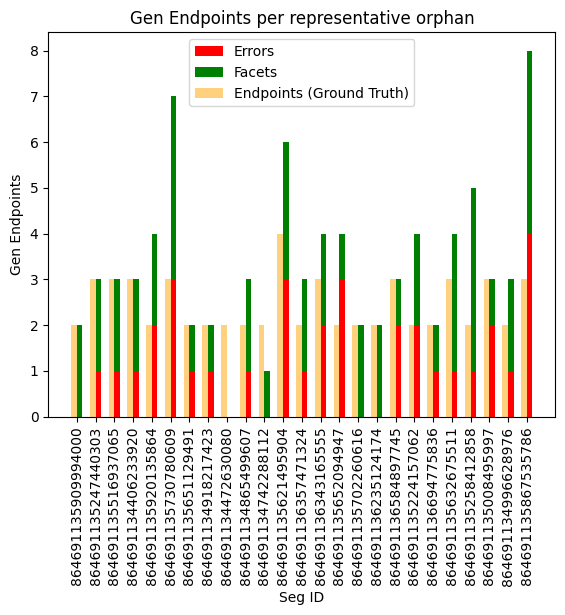

In [28]:
import matplotlib.pyplot as plt
import numpy as np

seg_ids = orphans_subset["seg_id"].astype(str)
num_gen_endpoints = orphans_subset["num_gen_endpoints"]
num_errors = orphans_subset["num_errors"]
num_facets = orphans_subset["num_facets"]

#gt endpoints
ground_truth_neuron_numbers = orphans_subset["neuron"].astype(str)
ground_truth_endpoints = orphans_subset["num_endpoints"]

# Set the positions of the bars on the x-axis
x = np.arange(len(seg_ids))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, num_errors, width, label='Errors', color='red')
rects3 = ax.bar(x + width, num_facets, width, bottom=num_errors, label='Facets', color='green')

# Create the bars for ground truth data
rects4 = ax.bar(x, ground_truth_endpoints, width, label='Endpoints (Ground Truth)', color='orange', alpha=0.5)

# Add labels, title, and legend
ax.set_ylabel('Gen Endpoints')
ax.set_xlabel('Seg ID')
ax.set_title('Gen Endpoints per representative orphan')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(seg_ids)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


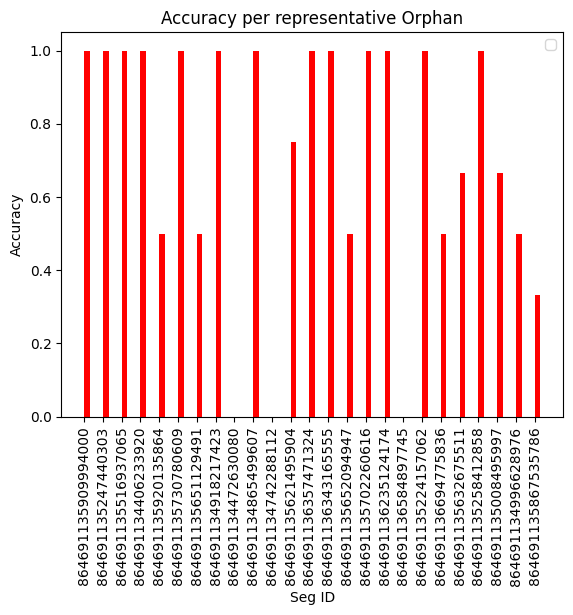

In [29]:
#accuracy plot for subset of 26 orphans
import matplotlib.pyplot as plt
import numpy as np

seg_ids = orphans_subset["seg_id"].astype(str)
accuracies = orphans_subset["accuracy"]

# Set the positions of the bars on the x-axis
x = np.arange(len(seg_ids))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, accuracies, width, color='red')


# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_xlabel('Seg ID')
ax.set_title('Accuracy per representative Orphan')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(seg_ids)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()


### Edge Cases + Exceptions